## CSC420 Assignment 4
### Brendan Neal | 1001160236 | nealbre1

Imports and some helper functions

In [129]:
import numpy as np
from scipy import spatial, cluster
import cv2 as cv
import math
import re
import os
import tensorflow as tf
from collections import Counter

from matplotlib import pyplot as plot

# Make the plot a certain size
plot.rcParams["figure.figsize"] = [8, 6]


def display_image(img, file_name=None, save_norm=True, save_type=np.uint8):
    """
    Shows an image (max-min normalized to 0-255), and saves it if a filename is given 
    save_norm = whether to save the normalized image
    save_type = what datatype to save the image as
    """
    
    flt_img = img.astype(float)
    img_max, img_min = np.max(flt_img), np.min(flt_img)
    norm = (((flt_img - img_min) / (img_max - img_min)) * 255).astype(np.uint8)
    
    if len(img.shape) == 2:
        plot.imshow(norm, cmap='gray')  
    elif (len(img.shape) == 3):
        plot.imshow(cv.cvtColor(norm, cv.COLOR_BGR2RGB))
    plot.show()
    
    to_save = norm if save_norm else flt_img
    if file_name:
        cv.imwrite(file_name, to_save)

#### Question 2a: Depth Calculation

Formula for depth calculation:
$$z = \frac{f \times b}{d}$$
Where:

$z$ : z-coordinate/depth of the pixel (meters)

$f$ : focal length of the camera(s) (pixels)

$b$ : base width of the two camera (meters)

$d$ : x-disparity of the pixel (pixels)

Code to grab calculate depth image and get camera params:

In [35]:
def depth_image(disparity_image, base_width, focal_length):
    """
    Creates a depth image using a disparity image and 
    some camera parameters (base width, focal length)
    """
    numerator = base_width * focal_length
    
    # Avoid div 0 errors
    denominator = disparity_image.astype(float)
    denominator[denominator == 0] = 1
    result = numerator / denominator
    
    # Set what should have been infinity to maximum
    result[denominator == 0] = np.max(result)
    
    return result


def get_camera_params(param_path):
    """
    Returns dictionary of camera parameter values 
    stored in the file at param_path
    """
    
    # Lines of the file are of form (param : value)
    line_regex = re.compile(r"(?P<param>(\w+)):(\s+)(?P<value>(\d+(\.\d+)?))")
    
    with open(param_path, "r") as file:
    
        # Matching the regex to the lines in the file
        matches = (line_regex.match(line) for line in file.readlines())
        
        # Organize the parameters into a dictionary for easy access
        return {
            match.group("param") : float(match.group("value"))
            for match in matches
        }

Running the above code for the first 3 images in the *test* folder:

004945


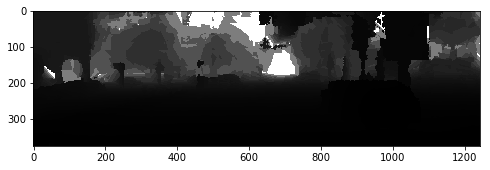

004964


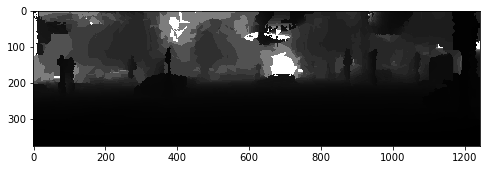

005002


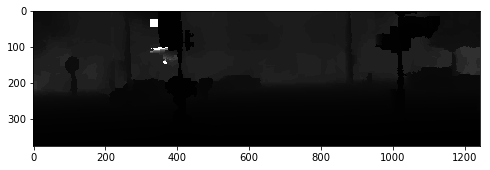

In [36]:
# Only need 3 image IDs in test
test_image_ids = [
    x.strip()
    for x in open("data/test/test.txt", "r").readlines()
]

for img_id in test_image_ids[:3]:
    camera_params = get_camera_params("data/test/calib/{}_allcalib.txt".format(img_id))
    disparity_img = cv.imread("data/test/results/{}_left_disparity.png".format(img_id), cv.IMREAD_GRAYSCALE)
    depth_img = depth_image(disparity_img, camera_params["baseline"], camera_params["f"])
    
    print(img_id)
    display_image(depth_img, "q2a-{}-depth.png".format(img_id), save_norm=False, save_type=np.float32)

#### Question 2b: Object Detection

Code to import and run a pre-trained tensorflow model:

In [37]:
def load_frozen_graph(model_folder):
    """
    Adapted from:
    https://blog.metaflow.fr/tensorflow-how-to-freeze-a-model-and-serve-it-with-a-python-api-d4f3596b3adc
    """
    # Load the graph definition
    frozen_graph_path = os.path.join(model_folder, r"frozen_inference_graph.pb")
    
    with tf.gfile.GFile(frozen_graph_path, "rb") as graph_file:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(graph_file.read())
        
    # Import the definition into a graph, return it
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name="")
        
    # Return the loaded graph
    return graph

def detect_objects(graph, image, threshold):
    """
    Adapted from: 
    https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb
    
    Changed to return numpy array of form:
    [[x_left, y_top, x_right, y_bottom, confidence, class]]
    
    Where each row represents a bounding box's diagonal coordinates, 
    confidence score and classification.
    """
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}

            for key in ['num_detections', 'detection_boxes', 'detection_scores', 
                        'detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)

            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)

            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})
                
            ###### MY OWN CODE TO CHANGE FORMAT OF OUTPUT #######
            img_height, img_width = image.shape[:2]
            num_detections = int(output["num_detections"][0])
            
            # Return a numpy array where each row has the following form:
            #     (y_top, x_left, y_bottom, x_right, confidence, class)
            # Coordinates are NOT normalized (they are actual image coordinates)
            classes = output["detection_classes"][0][:num_detections]
            box_coords = output["detection_boxes"][0][:num_detections] * np.array([img_height, img_width, img_height, img_width])
            scores = output["detection_scores"][0][:num_detections]
            
            # Stack the above matrices horizontally
            stacked = np.hstack((box_coords.astype(int), 
                                 scores.reshape(-1, 1), 
                                 classes.astype(int).reshape(-1, 1)))
            
            # Only take the rows where scores are above threshold
            return stacked[scores >= threshold]

Running code on images (using COCO-trained Mobile Net):
I am using a threshold of 0.3

In [38]:
coco_mobile_net = load_frozen_graph("coco-mobile-net")

for img_id in test_image_ids:
    img = cv.imread("data/test/left/{}.jpg".format(img_id))
    detections = detect_objects(coco_mobile_net, img, 0.3)
    
    # Save detections in test results folder
    np.save("data/test/results/{}_detections.npy".format(img_id), detections)

KeyboardInterrupt: 

#### Question 2c: Display First 3 Image Visualizations

In [ ]:
PERSON, BIKE, CAR, TRAFFIC_LIGHT = 1, 2, 3, 10

cls_to_name = {
    PERSON : "PERSON",
    BIKE : "BIKE",
    CAR : "CAR",
    TRAFFIC_LIGHT : "TRAFFIC LIGHT"
}

cls_to_col = {
    PERSON  : (255, 0, 0), # Blue
    BIKE  : (0, 255, 0), # Green
    CAR  : (0, 0, 255), # Red
    TRAFFIC_LIGHT : (255, 255, 0)# Cyan
}

for img_id in test_image_ids[:3]:
    detections = np.load("data/test/results/{}_detections.npy".format(img_id))
    img = cv.imread("data/test/left/{}.jpg".format(img_id))
    
    # Draw rectangles of detection on image
    for (y_top, x_left, y_bottom, x_right, confidence, cls) in detections:
        if cls in cls_to_name:
            top_lft = (int(x_left), int(y_top))
            bot_rgt = (int(x_right), int(y_bottom))
            
            
            cv.rectangle(img, top_lft, bot_rgt, cls_to_col[cls], 3)
            label_txt = cls_to_name[cls]
            label_coords = top_lft
            cv.putText(img, label_txt, label_coords, cv.FONT_HERSHEY_SIMPLEX, 0.65, cls_to_col[cls], 2)
    
    # Show the image
    print(img_id)
    display_image(img, "q2c-{}-detections.png".format(img_id))

#### Question 2d: Center of Mass Computation

Assuming points with equal mass, the center of mass of a collection of points will be the average point. However, note that within a detection box there are two distinct types of pixels: object and non-object pixels. If the object within the box is assumed to be the only object of significance, then the distribution of points will be bimodal between the object and the background pixels. Therefore, k-means clustering with k = 2 can be used to approximate the two means. 

The following formulas will be used to calculate each point $(x, y, z)$:

$$z = \frac{f \times b}{d}$$

$$x = \frac{x_L \times z}{f}$$

$$y = \frac{y_L \times z}{f}$$

Where:

$z$ : z-coordinate of the pixel (meters)

$x$ : x-coordinate of the pixel (meters)

$y$ : y-coordinate of the pixel (meters)

$f$ : focal length of the camera(s) (pixels)

$b$ : base width of the two camera (meters)

$d$ : x-disparity of the pixel (pixels)

$x_L$ : x-coordinate of the pixel in the left image (pixels)

$y_L$ : y-coordinate of the pixel in the left (or right, they're assumed to be the same) image (pixels)


In [130]:
def image_3d_coords(disparity, base_width, focal_length, center_x, center_y):
    """
    Produces an image where each pixel is of form [x, y, z]
    """
    
    # Compute Z/depth first
    z = depth_image(disparity, base_width, focal_length)
    
    # Shift raw coordinates by optical center
    raw_y, raw_x = np.indices(z.shape[:2])
    shifted_y, shifted_x = raw_y - center_y, raw_x - center_x
    
    # d = xL - xR --> xL = d + xR (assuming x-coordinates of disparity are xR)
    # y is assumed to be the same across both images
    yL = shifted_y
    xL = shifted_x + disparity
    
    x = (xL * z) / focal_length
    y = (yL * z) / focal_length
    
    return np.dstack((x, y, z))

def find_closest_mean(vectors, k):
    """
    Returns the mean vector with the smallest magnitude.
    (vectors is assumed to be a k-modal distribution)
    """
    
    # Run K-means
    centroids, labels = cluster.vq.kmeans2(vectors, k)
    
    # Determine magnitude of centroids
    centroid_mags = (centroids ** 2).sum(axis=1) ** 0.5
    closest_label = np.argmin(centroid_mags)
    
    # Return the closest centroid
    return centroids[closest_label]

def centers_of_mass(coords_3d, detections):
    """
    Takes an image of coordinates (each pixel is of form [x, y, z]), 
    and an array of detections each of form 
    [y_top, x_left, y_bottom, x_right, confidence, class] 
    
    Computes a numpy array of form [[x, y, z]], where the i-th element 
    is equal to the center of mass of the i-th detection's points
    """
    
    # Slices of given coordinate matrix (for each detection box)
    slice_inds = (
        row[:4].astype(int) 
        for row in detections
    )
    slices = (
        coords_3d[y_top:y_bottom, x_left:x_right]
        for (y_top, x_left, y_bottom, x_right) in slice_inds
    )
    
    # Flattened (x, y) slices
    flat_slices = (
        s.reshape(np.product(s.shape[:2]), 3)
        for s in slices
    )
    
    # Return closest mean of the bimodal distribution
    return np.array([
        find_closest_mean(vecs, 2)
        for vecs in flat_slices
    ])

Running the above code on each image (saving computed centers of mass and coordinates in results)

In [132]:
for img_id in test_image_ids[:3]:
    
    # Compute 3D coordinates of pixels
    camera_params = get_camera_params("data/test/calib/{}_allcalib.txt".format(img_id))
    disparity = cv.imread("data/test/results/{}_left_disparity.png".format(img_id), cv.IMREAD_GRAYSCALE)
    
    baseline, f, px, py = [camera_params[k] for k in ["baseline", "f", "px", "py"]]
    coords = image_3d_coords(disparity, baseline, f, px, py)
    
    # Detections of image
    detections = np.load("data/test/results/{}_detections.npy".format(img_id))
    
    # Centers of mass for each detection, in order of detections
    mass_centers = centers_of_mass(coords, detections)
    
    # Save the centers of mass and coordinates for each image
    np.save("data/test/results/{}_3d_coords.npy".format(img_id), coords)
    np.save("data/test/results/{}_mass_centers.npy".format(img_id), mass_centers)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\vq.py:660: UserWarning: One of the clusters is empty. Re-run kmean with a different initialization.
  warnings.warn("One of the clusters is empty. "


#### Question 2e: Segmentation Using 3D Coordinates and Centers of Mass

In [133]:
def segment_image(coords, detections, centers, max_dist):
    
    # The image to return
    ret = np.zeros(coords.shape, int)
    
    # Go through each detection
    for center, (y_top, x_left, y_bottom, x_right, confidence, cls) in zip(centers, detections):
        
        # Int-ify each bounding box coordinate for slicing
        yT, yB, xL, xR = int(y_top), int(y_bottom), int(x_left), int(x_right)
        
        # Get slice of coordinates and the center of mass
        coord_slice = coords[yT:yB, xL:xR]
        
        # Compute euclidean distance from center for each coordinate
        center_dists = ((coord_slice - center) ** 2).sum(axis=2) ** 0.5
        
        # Set the points within max_dist to the class color
        ret[yT:yB, xL:xR][center_dists < max_dist] = cls_to_col[cls]
    
    return ret

004945


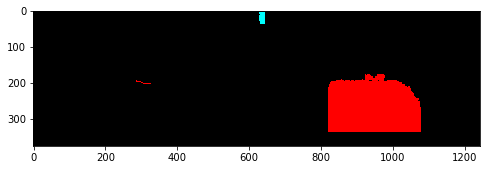

004964


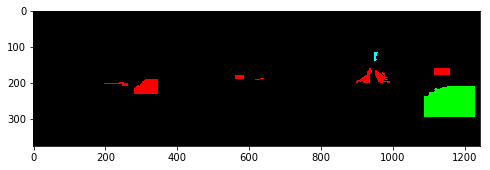

005002


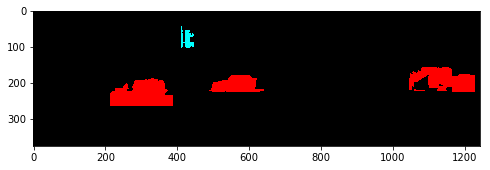

In [134]:
for img_id in test_image_ids[:3]:
    
    coords = np.load("data/test/results/{}_3d_coords.npy".format(img_id))
    centers = np.load("data/test/results/{}_mass_centers.npy".format(img_id))
    detections = np.load("data/test/results/{}_detections.npy".format(img_id))
    
    # Segment the image with maximum center-distance of 3 meters
    segmented = segment_image(coords, detections, centers, 3)
    
    print(img_id)
    display_image(segmented, "q2e-{}-segmentation.png".format(img_id))

#### Question 2f: Textual Description Generation

In [155]:
def make_description(detections, centers):
    class_counts = Counter(det[-1] for det in detections)
    
    # Determine distance of centroids from camera, then the closest center
    center_dists = (centers ** 2).sum(axis=1) ** 0.5
    closest_center_ind = np.argmin(center_dists)
    
    # Determine closest object's detection information
    closest_center = centers[closest_center_ind]
    closest_dist = center_dists[closest_center_ind]
    closest_detection = detections[closest_center_ind]
    
    return "\n".join([
        
        # Describe counts of classes
        "Number of Cars: {}".format(class_counts[CAR]),
        "Number of People: {}".format(class_counts[PERSON]),
        "Number of Cyclists: {}".format(class_counts[BIKE]),
        
        # Whether or not image has traffic light
        "Nearby Traffic Light: {}".format("Yes" if class_counts[TRAFFIC_LIGHT] else "No"),
        
        # Describe the closest detection
        "There is a {cls} {dst}m away - {horz_amt}m {horz_dir}, {vert_amt}m {vert_dir}, {depth_amt}m back".format(
            
            # Name of closest detection's class
            cls=cls_to_name[closest_detection[-1]].lower(),
            
            # Distance to closest detection
            dst=round(center_dists[closest_center_ind], 2),

            # Describing horizontal (x) displacement
            horz_amt = abs(round(closest_center[0], 2)), 
            horz_dir = "right" if closest_center[0] > 0 else "left",
            
            # Describing vertical (y) displacement - 
            # reverse because image coordinates are upside down
            vert_amt = abs(round(closest_center[1], 2)), 
            vert_dir = "down" if closest_center[1] > 0 else "up",
            
            # Describing depth (z) displacement
            depth_amt = abs(round(closest_center[2], 2))
        )
    ])
    

004945


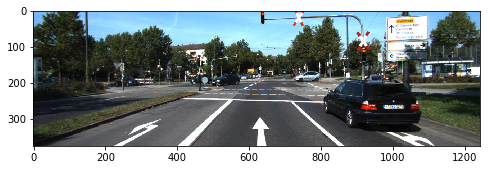

Number of Cars: 4
Number of People: 0
Number of Cyclists: 0
Nearby Traffic Light: Yes
There is a car 9.09m away - 4.23m right, 0.96m down, 7.98m back


004964


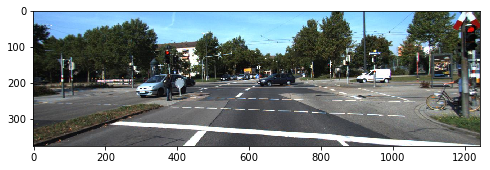

Number of Cars: 6
Number of People: 0
Number of Cyclists: 1
Nearby Traffic Light: Yes
There is a bike 13.41m away - 8.44m right, 1.13m down, 10.36m back


005002


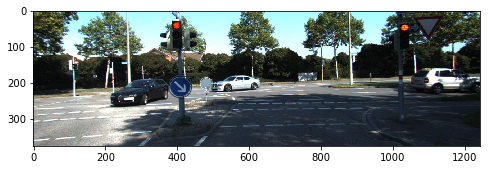

Number of Cars: 3
Number of People: 0
Number of Cyclists: 0
Nearby Traffic Light: Yes
There is a traffic light 7.98m away - 1.44m left, 1.03m up, 7.78m back




In [157]:
for img_id in test_image_ids[:3]:
    
    img = cv.imread("data/test/left/{}.jpg".format(img_id))
    detections = np.load("data/test/results/{}_detections.npy".format(img_id))
    centers = np.load("data/test/results/{}_mass_centers.npy".format(img_id))
    
    print(img_id)
    display_image(img)
    print(make_description(detections, centers))
    print("\n")